# Tutorial 2: 2D total precipitation from the ERA Interim dataset

In this tutorial we explore a reanalysis dataset provided with this package that contains total precipitation data over Earth. The data is two-dimensional on a longitude-latitude grid, and is part of the ERA Interim dataset provided by ECMWF (please, refer to ERA Interim for more details). The dataset was reduced to include only the period 2008-2017, on a longitude-latitude grid that was also downsampled by a factor 5.

## Import required libraries

The first step is to import the required libraries.

In [103]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import os
import sys
import numpy as np
from IPython.display import Video

# Current, parent and file paths
CWD = os.getcwd()
CFD = os.path.abspath('')

# project libraries
sys.path.append(os.path.join(CFD,"../../"))

# Import library specific modules
from pyspod.spod.standard  import Standard  as spod_standard
from pyspod.spod.streaming import Streaming as spod_streaming
import pyspod.spod.utils     as utils_spod
import pyspod.utils.weights  as utils_weights
import pyspod.utils.errors   as utils_errors
import pyspod.utils.io       as utils_io
import pyspod.utils.postproc as post

## Setup MPI Communicator for parallel computation (if available)

The second steps consists of setting up the MPI Communicator, if we want to run a parallel computation. 
This step requires that the user has a version of MPI installed in their machine / HPC system. Currently tested MPI platforms include Open MPI, and mpich. 

In [104]:
## -------------------------------------------------------------------
## initialize MPI
## -------------------------------------------------------------------
try:
    from mpi4py import MPI
    comm = MPI.COMM_WORLD
    rank = comm.rank
except:
    comm = None
    rank = 0
## -------------------------------------------------------------------

## Read data and parameters

We can now read the data and the parameters from `era_interim_data.nc`, and `input_tutorial2.yaml`, respectively. Both files are in `tests/data`. The input file contains some parameters that are required and some that are optional. 

In detail:

```yaml
required:
  - time_step   : 12 #hours
  - n_space_dims: 2
  - n_variables : 1
  - n_dft       : 730

optional:
  - overlap          : 0
  - mean_type        : 'longtime'
  - normalize_weights: False
  - normalize_data   : False
  - n_modes_save     : 40
  - conf_level       : 0.95
  - reuse_blocks     : False
  - savefft          : False
  - dtype            : 'single'
  - savedir          : 'spod_results'
  - fullspectrum     : False

```

The **required parameters** are:
- `time_step`, the time step of the data, 
- `n_space_dims`, the number of spatial dimensions of the data; for 2D data this number is equal to 2, 
- `n_variables`, the number of variables; for one single field, e.g., pressure, this number is equal to 1,
- `n_dft`, the number of time snapshots in each block for the data partitioning; for this tutorial, we are using 64 time snapshots, for a dataset containing 1000 time snapshots. This means that our data will be divided into blocks of 64 time snapshots each.

The **optional parameters** are:
- `overlap`, that is whether to use an overlap region between blocks (in percentage),
- `mean_type`, the type of mean to be used; this can either be the mean of all time snapshots (`longtime`), or the the mean of each block (`blockwise`); it can also be set to `zero`, if the mean was already removed from the data,
- `normalize_weights`, whether or not to normalize the weights,
- `normalize_data`, whether or not to normalize the data,
- `n_modes_save`, the number of modes to be saved,
- `conf_level`, the confidence interval for the eigenvalues,
- `reuse_blocks`, whether to reuse pre-computed FFT blocks (if present),
- `savefft`, whether to save the FFT blocks,
- `dtype`, the data type to be used (either `single` or `double` precision),
- `savedir`, where to save the results,
- `fullspectrum`, whether to use a full spectrum (instead of half) for the FFT.

In [105]:
## -------------------------------------------------------------------
## read data and params
## -------------------------------------------------------------------
## data
data_file = os.path.join(CFD, '../../tests/data/', 'era_interim_data.nc')
ds = utils_io.read_data(data_file=data_file)
print(ds)
## we extract time, longitude and latitude
t = np.array(ds['time'])
x1 = np.array(ds['longitude']) - 180
x2 = np.array(ds['latitude'])
data = ds['tp']
nt = len(t)
print('shape of t (time): ', t.shape)
print('shape of x1 (longitude): ', x1.shape)
print('shape of x2 (latitude) : ', x2.shape)
## params
config_file = os.path.join(CFD, '../../tests/data', 'input_tutorial2.yaml')
params = utils_io.read_config(config_file)
## -------------------------------------------------------------------

<xarray.Dataset> Size: 192MB
Dimensions:    (longitude: 80, latitude: 41, time: 7305)
Coordinates:
  * longitude  (longitude) float32 320B 0.0 4.5 9.0 13.5 ... 346.5 351.0 355.5
  * latitude   (latitude) float32 164B 90.0 85.5 81.0 76.5 ... -81.0 -85.5 -90.0
  * time       (time) datetime64[ns] 58kB 2008-01-01T03:00:00 ... 2017-12-31T...
Data variables:
    tp         (time, latitude, longitude) float64 192MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-07-13 13:05:17 GMT by grib_to_netcdf-2.22.0: grib_to_n...
shape of t (time):  (7305,)
shape of x1 (longitude):  (80,)
shape of x2 (latitude) :  (41,)


## Set trapezoidal weights for geospatial grid

In this case, given that the data in not equally spaced, we need to setup some spatial weights. These are conveniently provided as part of the package for geophysical grids, like the one used in this tutorial, as well as many climate renalysis datasets, such as ERA5 and ERA Interim.

In [106]:
## set weights
weights = utils_weights.geo_trapz_2D(
    x1_dim=x2.shape[0], x2_dim=x1.shape[0],
    n_vars=params['n_variables'])

## Compute SPOD modes

We can then initialize the SPOD algorithms, both the batch (`standard`) and the streaming (`streaming`) one:

- `standard  = spod_standard (params=params, comm=comm)`
- `streaming = spod_streaming(params=params, comm=comm)`

and compute the **SPOD modes $\phi(\mathbf{x})$**, using `spod = standard.fit(data_list=data)`.

We can also check the orthogonality of the modes using `check_orthogonality`.
The modes provided should return `flag = True`, and `ortho < 1e-8` (the reanalysis data is provided in single precision).

In [107]:
## -------------------------------------------------------------------
## compute spod modes and check orthogonality
## -------------------------------------------------------------------
standard  = spod_standard (params=params, weights=weights, comm=comm)
streaming = spod_streaming(params=params, weights=weights, comm=comm)
spod = standard.fit(data_list=data)
results_dir = spod.savedir_sim
flag, ortho = utils_spod.check_orthogonality(
    results_dir=results_dir, mode_idx1=[1],
    mode_idx2=[0], freq_idx=[5], dtype='single',
    comm=comm)
print(f'flag = {flag},  ortho = {ortho}')
## -------------------------------------------------------------------

 
Initialize data ...
 
Initialize data
------------------------------------
- reading first time snapshot for data dimensions
- getting data dimensions
nx: 3280
dim: 4
shape: (1, 41, 80, 1)
xdim: 2
xshape: (41, 80)
nt: 7305
- checking weight dimensions
- distributing data (if parallel)
--- reading data (1 stage reader) finished in 0.29 s
- loaded data into memory: 1.1920928955078125e-06 s.
- computed mean: 0.004912853240966797 s.
SPOD parameters
------------------------------------
Problem size (real)      : 0.09 GB (min 0.09 GB/proc, max 0.09 GB/proc)
Problem size (complex)   : 0.18 GB (min 0.18 GB/proc, max 0.18 GB/proc)
Data type for real       : <class 'numpy.float32'>
Data type for complex    : <class 'numpy.complex64'>
No. snapshots per block  : 730
Block overlap            : 0
No. of blocks            : 10
Windowing fct. (time)    : hamming
Weighting fct. (space)   : geo_trapz_2D
Mean                     : longtime
Number of frequencies    : 366
Time-step                : 12
Ti

## Compute time coefficients

Once the modes are computed, we can calculate the **time coefficients $a(t)$**

In [108]:
## -------------------------------------------------------------------
## compute coefficients
## -------------------------------------------------------------------
file_coeffs, coeffs_dir = utils_spod.compute_coeffs_op(
    data=data, results_dir=results_dir, comm=comm)
## -------------------------------------------------------------------


Computing coefficients
------------------------------
- identified frequencies: 0.285022497177124 s.
- data and time mean: 0.06247067451477051 s.
- retrieved modes: 1.8511099815368652 s.
- oblique projection done: 24.750733137130737 s.
- saving completed: 0.5286760330200195 s.
-----------------------------------------
Coefficients saved in folder: e:\5_Dev\Github\PySPOD\tutorials\tutorial2\spod_results\nfft730_novlp0_nblks10\coeffs_0_365\coeffs.npy
Elapsed time: 27.4795184135437 s.


## Reconstruct original data

From the SPOD modes $\phi(\mathbf{x})$ and the time coefficients $a(t)$, we can finally **reconstruct the original data**

In [109]:
## -------------------------------------------------------------------
## compute reconstruction
## -------------------------------------------------------------------
file_dynamics, coeffs_dir = utils_spod.compute_reconstruction(
    coeffs_dir=coeffs_dir, time_idx=[0,1,2,3,4,5,6,7,8,9,10],
    comm=comm)
## -------------------------------------------------------------------


Reconstructing data from coefficients
------------------------------------------
- phi x a completed: 0.07393527030944824 s.
- added time mean: 0.00019979476928710938 s.
- data saved: 0.4640007019042969 s.
--------------------------------------------
Reconstructed data saved in: e:\5_Dev\Github\PySPOD\tutorials\tutorial2\spod_results\nfft730_novlp0_nblks10\coeffs_0_365\reconstructed.npy
Elapsed time: 0.46405863761901855 s.


Finally, we can perform some **postprocessing** and **visualization**

## Postprocessing and visualization

### Eigenvalues

We can first plot the eigenvalues in the complex plane, as well as the eigenvalues vs frequency and period.

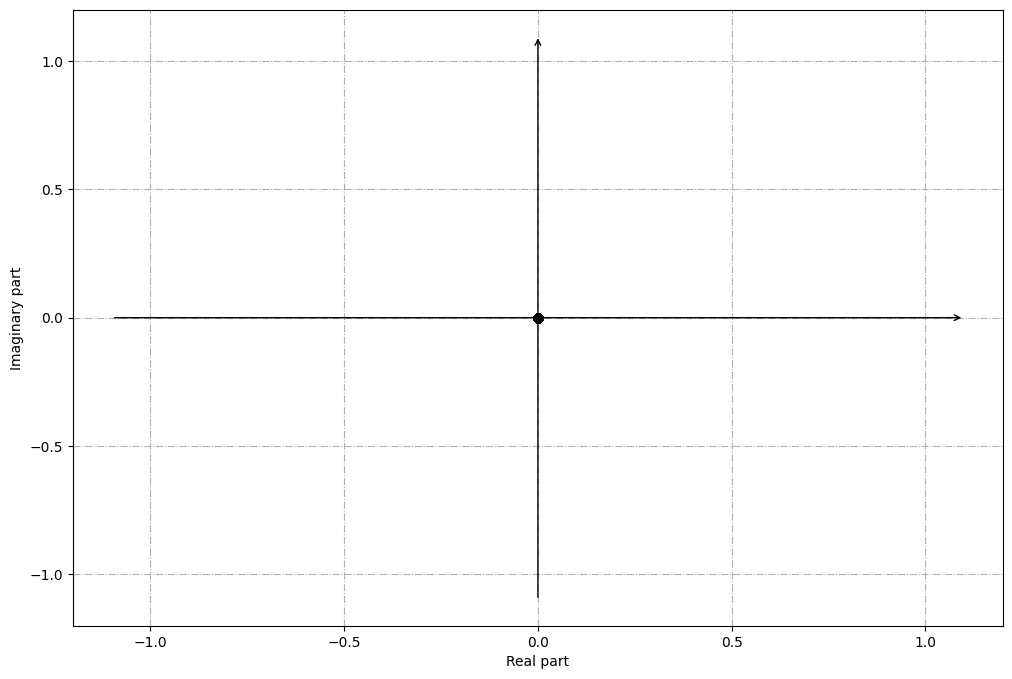

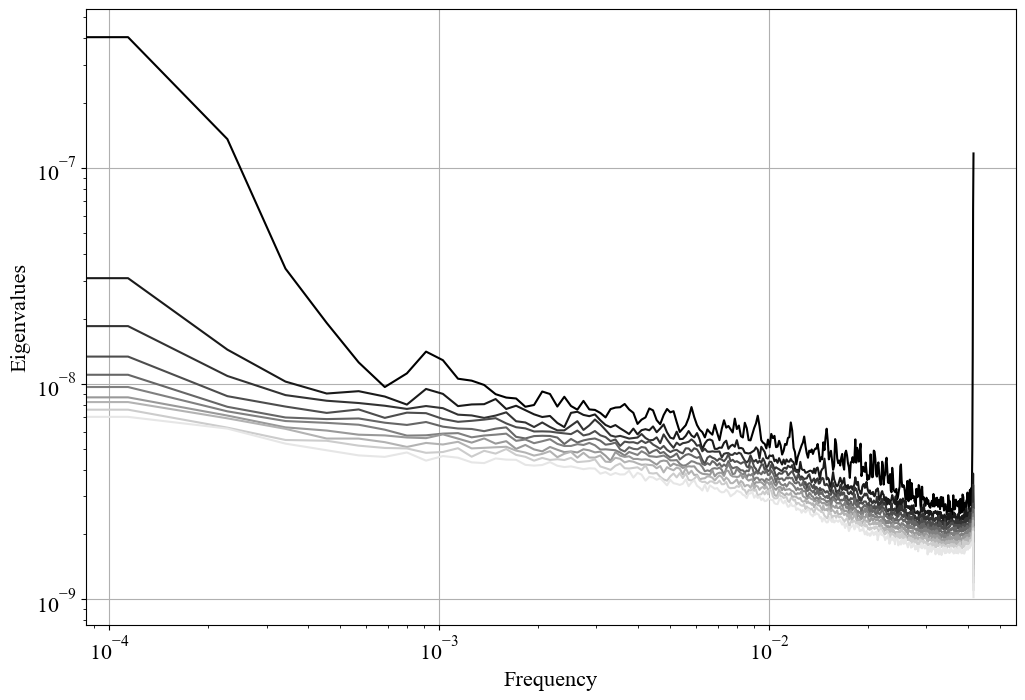

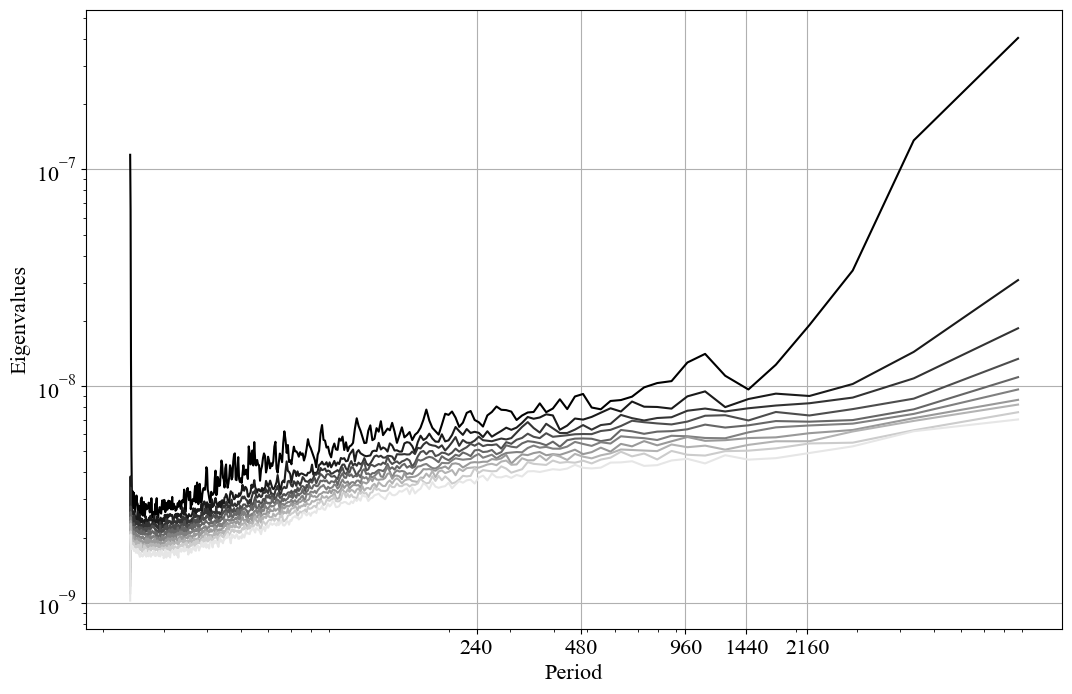

In [110]:
## only rank 0
if rank == 0:
    ## plot eigenvalues
    spod.plot_eigs()
    spod.plot_eigs_vs_frequency()
    spod.plot_eigs_vs_period(xticks=[24*10,24*20,24*40,24*60,24*90])

### SPOD modes

We can then plot the SPOD modes at some prescribed frequencies (equivalently periods) of interest. 
In this case we chose 
- period 1, T1 = 960 hours, and 
- period 2, T2 = 1008 hours.

The approx average period of the Madden-Julian Oscillation (MJO) is 1008 hours. In the eigenvalues vs period figure above, we can indeed see a distinct peak at this period, although broadband, as expected for MJO. 

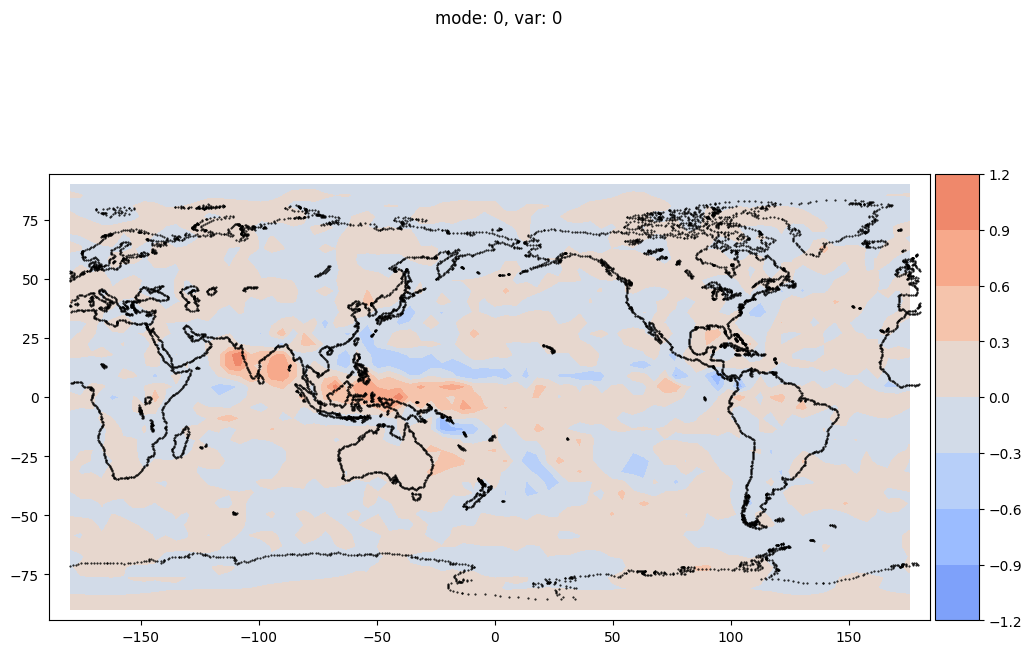

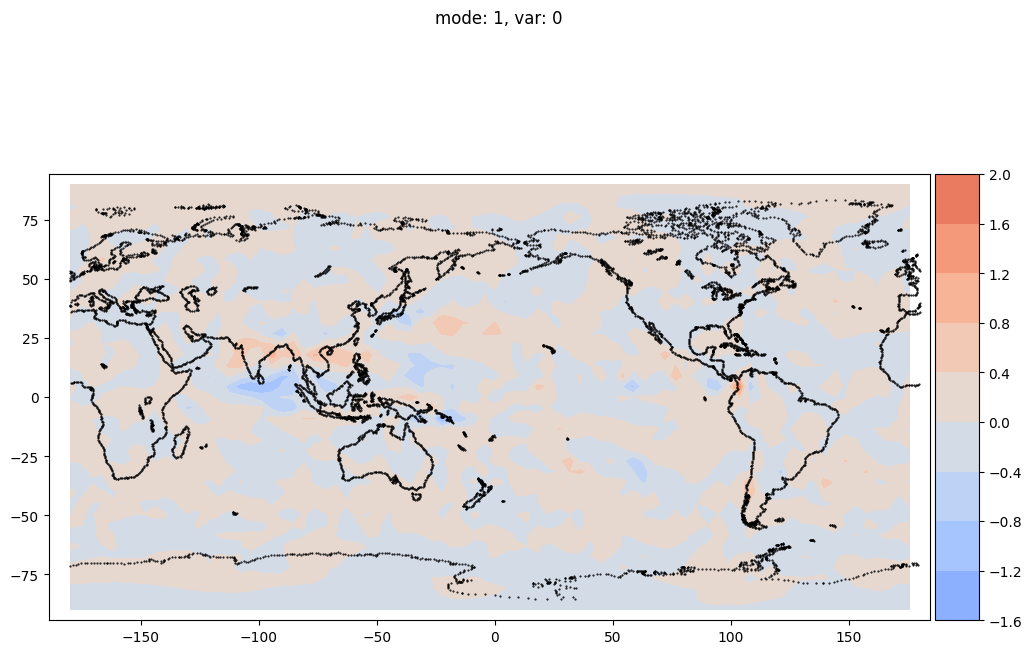

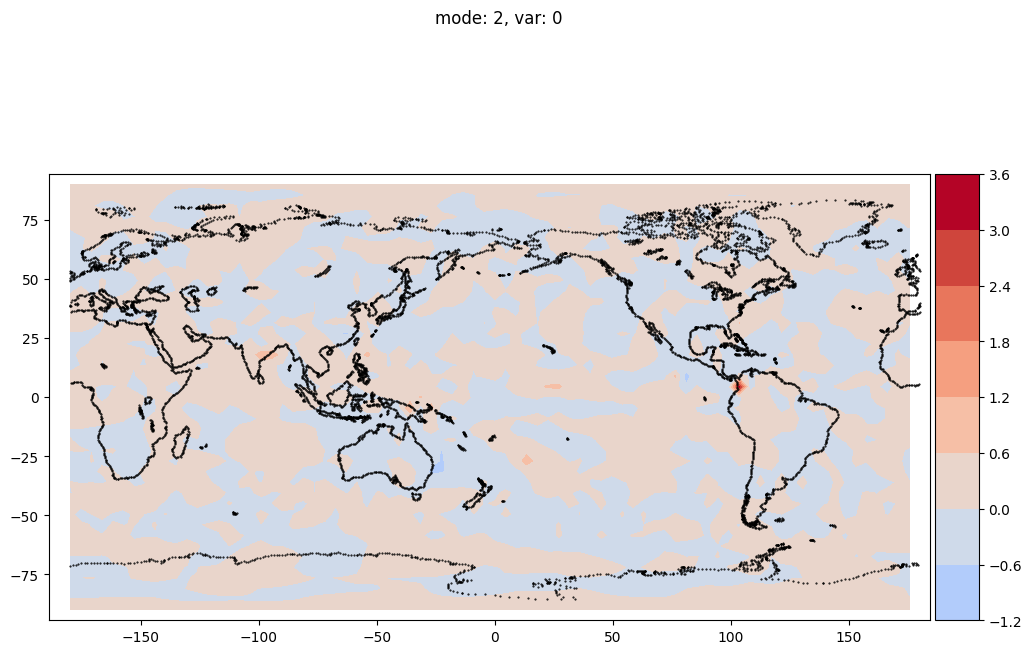

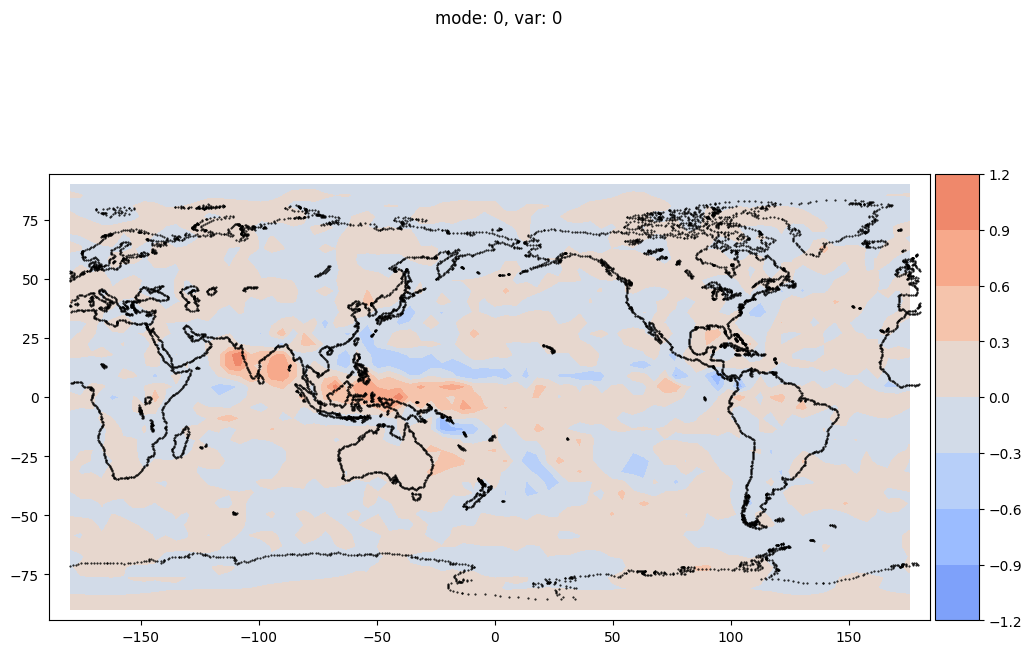

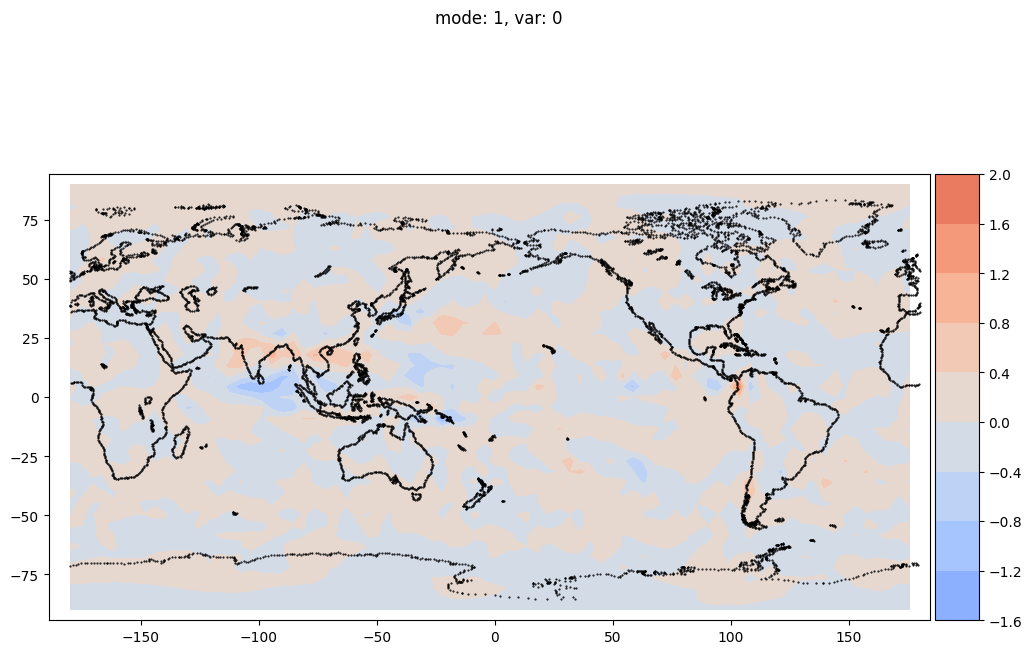

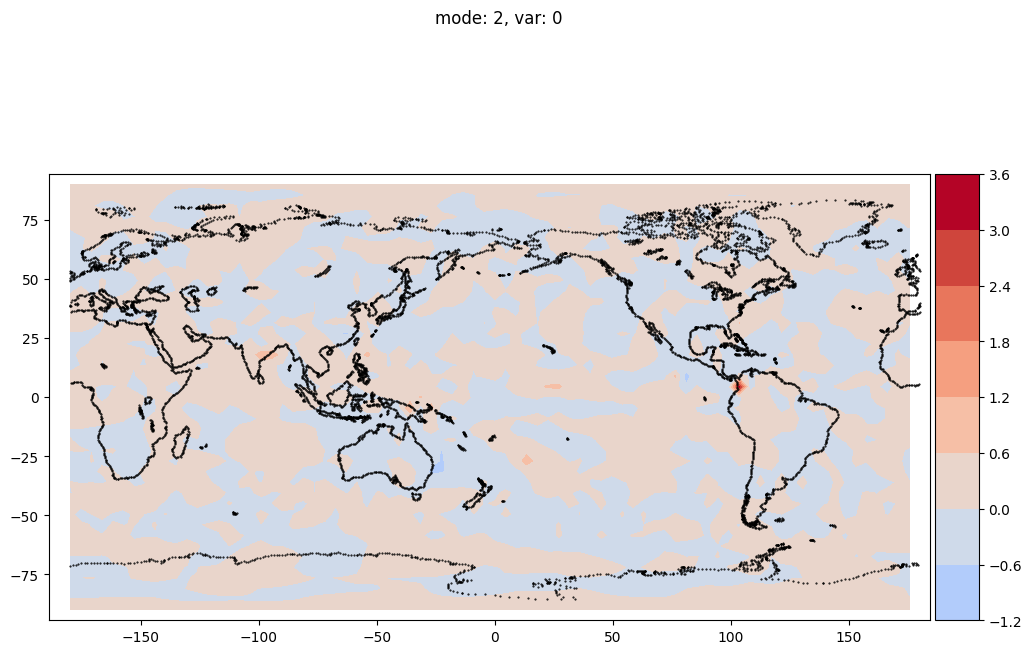

In [111]:
## only rank 0
if rank == 0:
    ## identify frequency of interest
    T1 = 960; T2 = 1008
    f1, f1_idx = spod.find_nearest_freq(freq_req=1/T1, freq=spod.freq)
    f2, f2_idx = spod.find_nearest_freq(freq_req=1/T2, freq=spod.freq)

    ## plot 2d modes at frequency of interest
    spod.plot_2d_modes_at_frequency(freq_req=f1, freq=spod.freq,
        modes_idx=[0,1,2], x1=x1, x2=x2, coastlines='centred',
        equal_axes=True)

    ## plot 2d modes at frequency of interest
    spod.plot_2d_modes_at_frequency(freq_req=f2, freq=spod.freq,
        modes_idx=[0,1,2], x1=x1, x2=x2, coastlines='centred',
        equal_axes=True)



### Time coefficients

We can also visualize the time coefficients

c:\Users\weihx\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\weihx\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


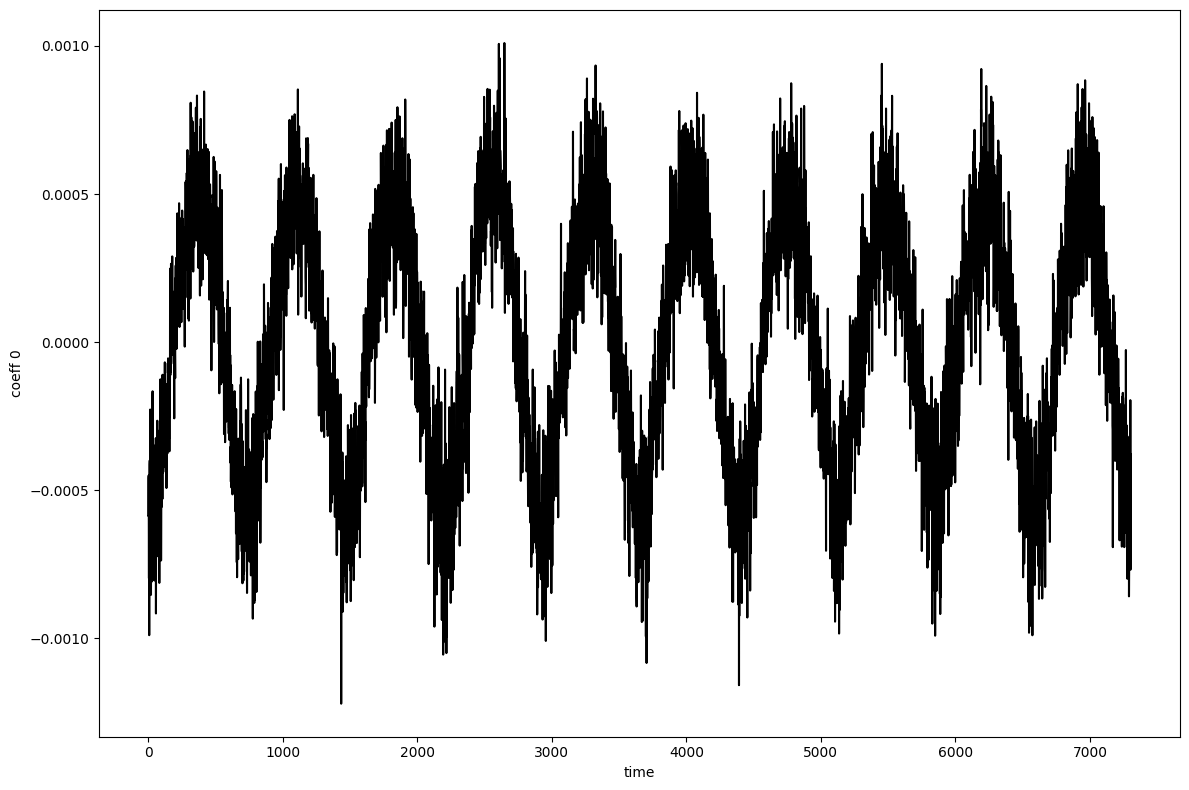

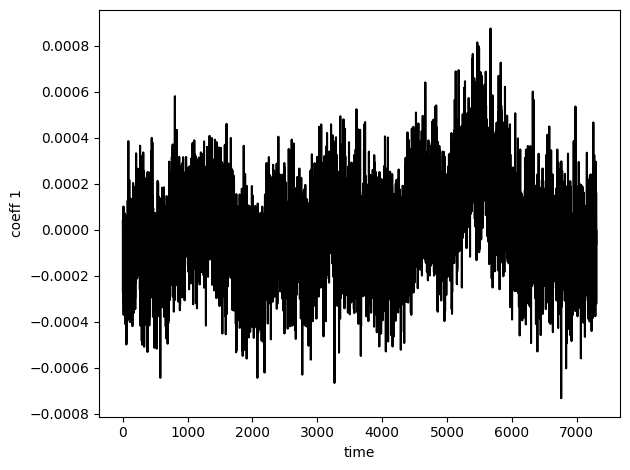

In [112]:
## only rank 0
if rank == 0:    
    ## plot coefficients
    coeffs = np.load(file_coeffs)
    post.plot_coeffs(coeffs, coeffs_idx=[0,1], path=results_dir)

  

### Reconstruction of the solution

We then visualize the reconstruction of the data based on the SPOD modes and time coefficients.

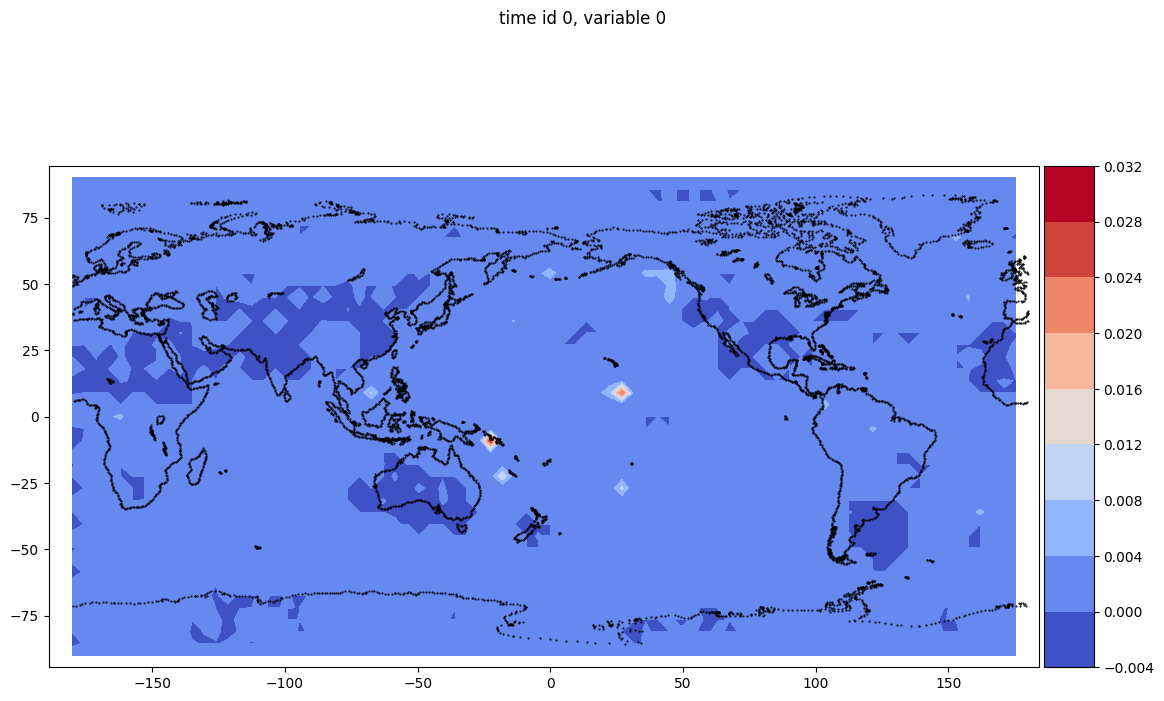

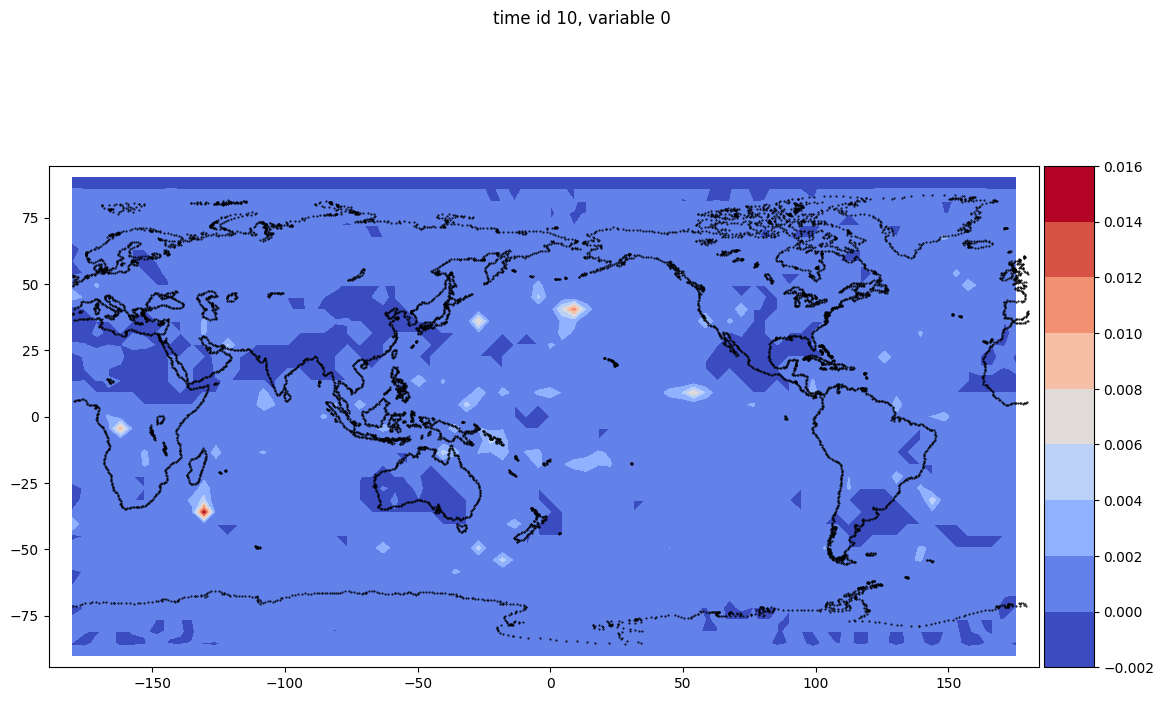

In [113]:
## only rank 0
if rank == 0:
    # plot reconstruction
    recons = np.load(file_dynamics)
    post.plot_2d_data(recons, time_idx=[0,10],
        path=results_dir, x1=x1, x2=x2, coastlines='centred',
        equal_axes=True)



### The original data

We can also visualize the original data, both in terms of 2D contours or data tracers.

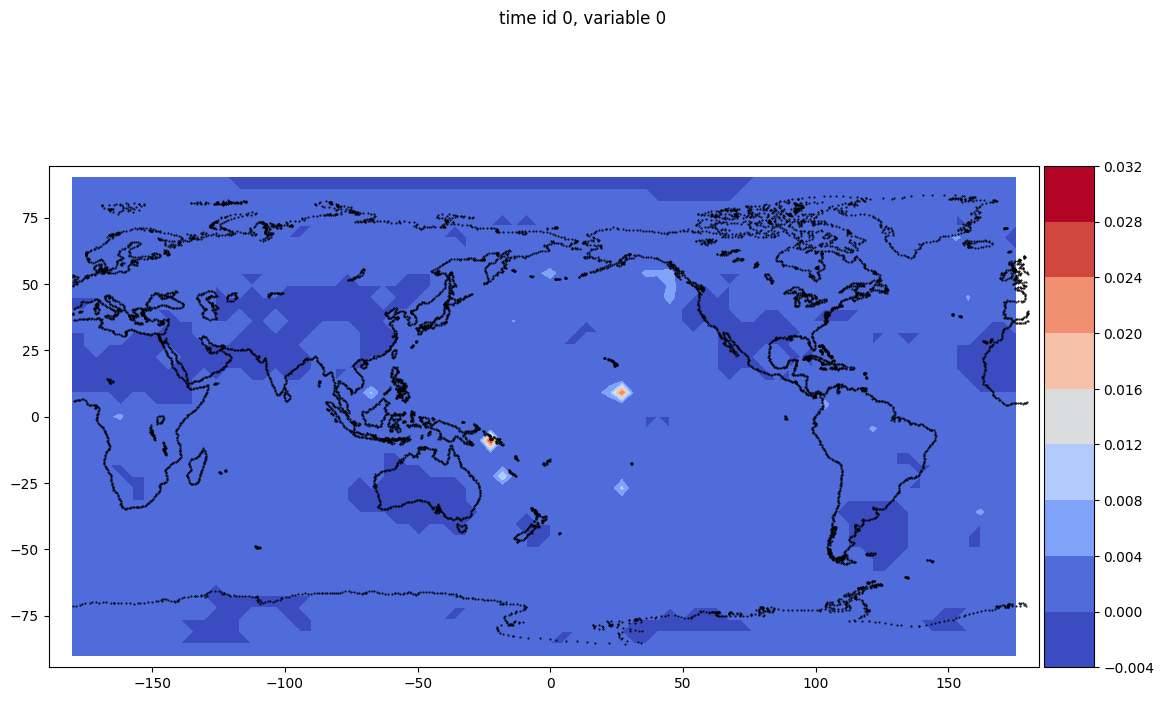

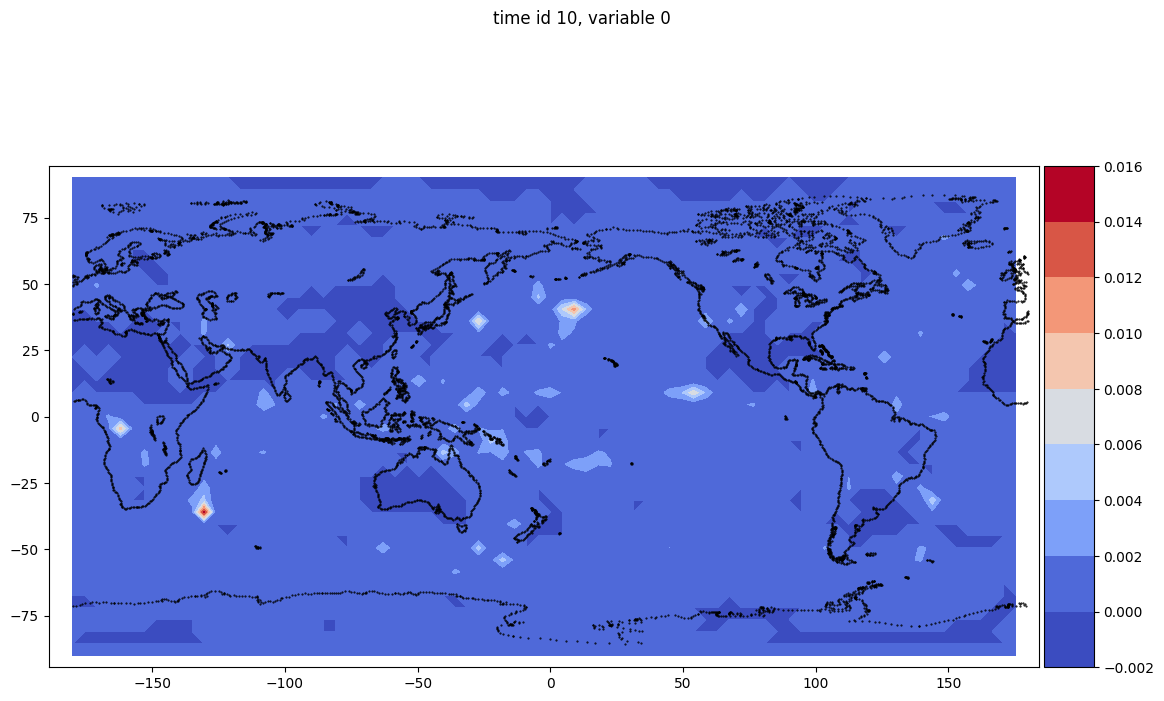

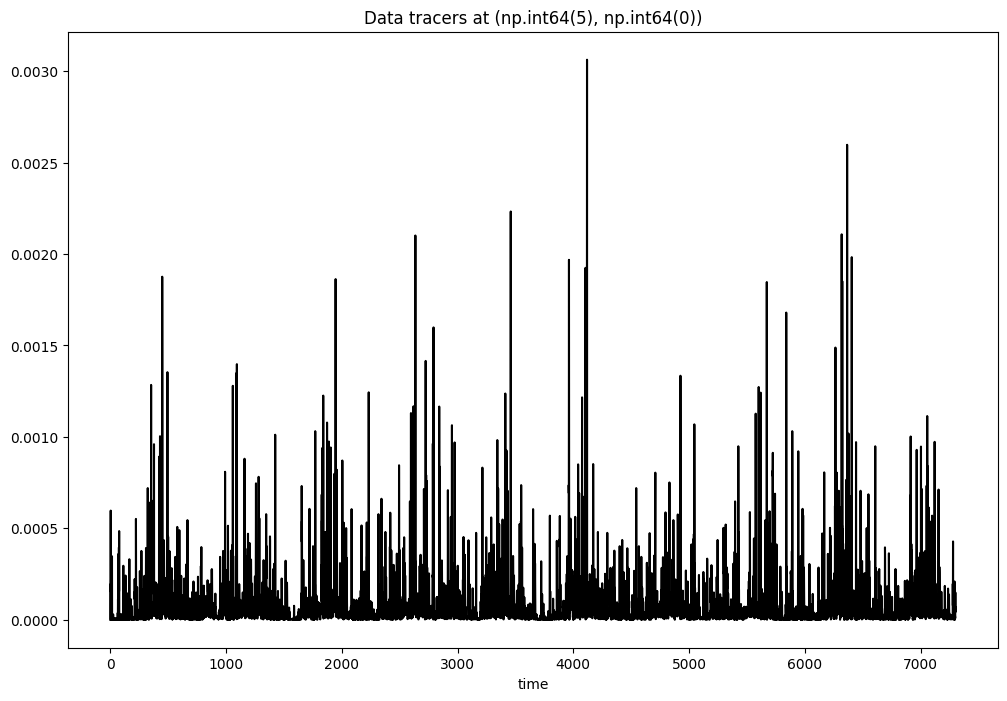

Skipping creating ffmpeg video as `ffmpeg` not present.


ValueError: To embed videos, you must pass embed=True (this may make your notebook files huge)
Consider passing Video(url='...')

In [ ]:
## only rank 0
if rank == 0:
    ## plot data
    data_plot = spod.get_data(data.values)
    post.plot_2d_data(data_plot, time_idx=[0,10],
        path=results_dir, x1=x1, x2=x2, coastlines='centred',
        equal_axes=True)
    post.plot_data_tracers(data_plot, coords_list=[(5,0.5)],
        time_limits=[0,nt], path=results_dir)
    '''
    post.generate_2d_data_video(
        data, sampling=5, time_limits=[0,nt],
        x1=x1, x2=x2, coastlines='centred',
        path=results_dir, filename='data_movie1.mp4')
    # play the video
    video_path = results_dir + '/data_movie1.mp4'
    Video(video_path)
    '''
    ## -------------------------------------------------------------